In [1]:
from astroquery.svo_fps import SvoFps
import numpy as np
from astropy.table import Table
from synphot import SourceSpectrum, Observation, units, SpectralElement
from synphot.models import Empirical1D
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from specutils import Spectrum1D


In [2]:
# Get the list of OAJ/JPCam filters
JPAS_filter_list = SvoFps.get_filter_list(facility='OAJ', instrument='JPCam').to_pandas()
# Filters of interest (56 narrow - J0378)
JPAS_filter_ids = ('OAJ/JPAS.J0390', 'OAJ/JPAS.J0400',
                   'OAJ/JPAS.J0410', 'OAJ/JPAS.J0420', 'OAJ/JPAS.J0430', 'OAJ/JPAS.J0440', 'OAJ/JPAS.J0450',
                   'OAJ/JPAS.J0460', 'OAJ/JPAS.J0470', 'OAJ/JPAS.J0480', 'OAJ/JPAS.J0490',
                   'OAJ/JPAS.J0500', 'OAJ/JPAS.J0510', 'OAJ/JPAS.J0520', 'OAJ/JPAS.J0530', 'OAJ/JPAS.J0540',
                   'OAJ/JPAS.J0550', 'OAJ/JPAS.J0560', 'OAJ/JPAS.J0570', 'OAJ/JPAS.J0580', 'OAJ/JPAS.J0590',
                   'OAJ/JPAS.J0600', 'OAJ/JPAS.J0610', 'OAJ/JPAS.J0620', 'OAJ/JPAS.J0630',
                   'OAJ/JPAS.J0640', 'OAJ/JPAS.J0650', 'OAJ/JPAS.J0660', 'OAJ/JPAS.J0670', 'OAJ/JPAS.J0680',
                   'OAJ/JPAS.J0690', 'OAJ/JPAS.J0700', 'OAJ/JPAS.J0710', 'OAJ/JPAS.J0720', 'OAJ/JPAS.J0730',
                   'OAJ/JPAS.J0740', 'OAJ/JPAS.J0750', 'OAJ/JPAS.J0760', 'OAJ/JPAS.J0770',
                   'OAJ/JPAS.J0780', 'OAJ/JPAS.J0790', 'OAJ/JPAS.J0800', 'OAJ/JPAS.J0810', 'OAJ/JPAS.J0820',
                   'OAJ/JPAS.J0830', 'OAJ/JPAS.J0840', 'OAJ/JPAS.J0850', 'OAJ/JPAS.J0860', 'OAJ/JPAS.J0870',
                   'OAJ/JPAS.J0880', 'OAJ/JPAS.J0890', 'OAJ/JPAS.J0900', 'OAJ/JPAS.J0910')
# Filters transmission data
JPAS_waveRefAA = {} # WavelengthRef dict
JPAS_bp = {} # Bandpass dict
for filter_id in JPAS_filter_ids:
    JPAS_filter_tx = SvoFps.get_transmission_data(filter_id)
    JPAS_waveRefAA[filter_id] = JPAS_filter_list[JPAS_filter_list.filterID==filter_id].WavelengthRef.values[0]
    JPAS_bp[filter_id] = SpectralElement(Empirical1D, points=JPAS_filter_tx['Wavelength'], lookup_table=JPAS_filter_tx['Transmission'])


In [3]:
RKcat_cb_spec_class=Table.read('tables/cbdata_pre_final.ecsv')


In [4]:
%%capture cell_output
#                       SDSS            BOSS
# Wavelength coverage 	3800-9200 Å 	3650-10,400 Å

dfCVmags = pd.DataFrame()
for i in range(len(RKcat_cb_spec_class)):
    p = RKcat_cb_spec_class[i]['plate']
    m = RKcat_cb_spec_class[i]['mjd']
    f = RKcat_cb_spec_class[i]['fiberID']
    filename = 'spec-'+str(p).zfill(4)+'-'+str(m)+'-'+str(f).zfill(4)+'.fits'
    sp = Spectrum1D.read('cbdata_w_spec/'+filename)
    # Fotometría
    JPAS_obs_effstim = {}
    good = True
    for k in JPAS_bp:
        try:
            obs = Observation(sp, JPAS_bp[k], force='taper')
        except:
            good = False
        JPAS_obs_effstim[k[9:]] = round(obs.effstim(u.ABmag).value, 4)
    dfEffstim = pd.DataFrame.from_dict([JPAS_obs_effstim])
    dfObj = pd.DataFrame(columns=['class', 'plate', 'mjd', 'fiber', 'good'])
    dfObj = dfObj.append(pd.Series({'class':'CV', 'plate':p, 'mjd':m, 'fiber':f, 'good':good}), ignore_index=True)
    concatenated_dataframes = pd.concat([dfObj, dfEffstim], axis=1)
    dfCVmags = dfCVmags.append(concatenated_dataframes, ignore_index=True)


In [5]:
dfCVmags.to_csv('tables/cv_mag.csv', index=False)


In [6]:
dfCVmags = pd.read_csv('tables/cv_mag.csv')
dfCVmags


,class,plate,mjd,fiber,good,J0390,J0400,J0410,J0420,J0430,...,J0820,J0830,J0840,J0850,J0860,J0870,J0880,J0890,J0900,J0910
0,CV,1916,53269,424,True,17.2737,17.3589,17.3420,17.4940,17.2049,...,15.9307,15.9274,15.9068,15.8799,15.8895,15.8850,15.8483,15.8476,15.8479,15.8121
1,CV,635,52145,387,True,17.5318,17.6467,17.6285,17.8215,17.4566,...,16.0421,16.0398,16.0194,15.9717,15.9718,15.9497,15.9389,15.9506,15.9508,15.9145
2,CV,1468,52999,163,True,17.6002,17.7148,17.7002,17.9280,17.6191,...,16.7773,16.7757,16.7763,16.7670,16.7540,16.7361,16.7262,16.7704,16.7634,16.7547
3,CV,439,51877,582,True,19.8255,19.6789,19.5170,19.5924,19.3274,...,17.2581,17.2465,17.2542,17.2151,17.1992,17.1841,17.1608,17.1527,17.1259,17.0471
4,CV,3686,55268,46,True,18.4175,18.5666,18.5130,18.7694,18.3293,...,16.9848,16.9741,16.9608,16.9337,16.9309,16.9276,16.9210,16.9271,16.9033,16.8551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,CV,4494,55569,72,True,18.1685,18.1298,18.3218,18.4809,18.5303,...,18.5325,18.5201,18.5028,18.4873,18.4842,18.4695,18.4556,18.4412,18.4304,18.3269
290,CV,2062,53381,22,True,19.6721,19.7700,19.7837,19.7580,19.7907,...,20.7106,20.8218,20.7339,20.8178,21.0406,20.8381,20.5716,20.6713,20.6931,20.8623
291,CV,2922,54612,406,True,19.2764,19.3913,19.3989,19.3798,19.4096,...,19.9295,19.8617,19.8449,20.0219,20.1631,19.9825,19.7924,19.6884,19.8122,19.9799
292,CV,336,51999,358,True,19.4675,19.5747,19.5457,19.5092,19.5562,...,20.1608,20.2732,20.2594,20.2946,20.0895,20.0733,20.2890,20.0587,20.4395,20.2959


Text(0.5, 1.0, 'Plugging 442-51882-494')

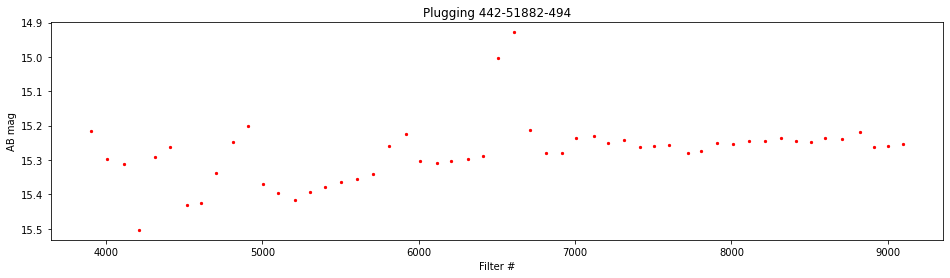

In [10]:
import matplotlib.pyplot as plt
a = dfCVmags.iloc[[36]]
df1 = a.iloc[:,5:59]
plt.figure(figsize=(16,4))
#plt.plot(df1.values[0])
plt.scatter(JPAS_waveRefAA.values(), df1.values[0], s=5, c='r')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.xlabel('Filter #')
plt.ylabel('AB mag')
plt.title('Plugging '+str(a.plate.values[0])+'-'+str(a.mjd.values[0])+'-'+str(a.fiber.values[0]))
